In [1]:
import redshift_connector
import pandas as pd
pd.set_option("display.max_colwidth", None)
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from collections import Counter

In [2]:
with open("redshift_creds.txt", "r") as f:
    host = f.readline()[:-1]
    password= f.readline()[:-1]

In [3]:
conn = redshift_connector.connect(
     host=host,
     database='dev',
     user='app_user',
     password=password
  )

In [4]:
# conn.close()

In [5]:
cursor = conn.cursor()

#### Looking at all tables needed

In [8]:
cursor.execute("ROLLBACK;")
cursor.execute("SELECT DISTINCT tablename FROM pg_table_def")
result = cursor.fetchall()
for i in result:
    if i[0].startswith('mag_main') | i[0].startswith('mag_advanced'):
        print(i[0])

mag_advanced_entity_related_entities
mag_advanced_field_of_study_children
mag_advanced_field_of_study_extended_attributes
mag_advanced_fields_of_study
mag_advanced_paper_fields_of_study
mag_advanced_paper_mesh
mag_advanced_paper_recommendations
mag_advanced_related_field_of_study
mag_main_affiliations
mag_main_author_extended_attributes
mag_main_authors
mag_main_conference_instances
mag_main_conference_series
mag_main_journals
mag_main_paper_author_affiliations
mag_main_paper_extended_attributes
mag_main_paper_references_id
mag_main_paper_resources
mag_main_paper_urls
mag_main_papers


#### Checking the column names for a specific table

In [55]:
query = """SELECT *
  FROM information_schema.columns
 WHERE table_name   = 'mag_main_affiliations'"""

cursor.execute("ROLLBACK;")
cursor.execute(query)
result = cursor.fetchall()
for i in result:
    print(i[3])

citation_count
paper_family_count
paper_count
rank
created_date
iso3166_code
wiki_page
official_page
grid_id
display_name
normalized_name
affiliation_id
longitude
latitude


### Looking at some papers

##### The following query "explodes" the hierarchy to add tags. Not sure if this method will be used in training. Might stick with the given tags so that the model does not get confused. I don't think I want multiple level 0s to be tagged every time which is what seems might happen if the exploding hierarchy is used.

In [240]:
journal_join_query = \
"""
SELECT  a.paper_id, a.doc_type, a.paper_title, a.year, 
        a.publication_date, a.journal_id, b.normalized_name,
        c.field_of_study, d.normalized_name as topic_name, d.display_name,
        d.rank, f.parent_name, f.parent_level, h.parent2_name, h.parent2_level,
        j.parent3_name, j.parent3_level
FROM (SELECT paper_id, doc_type, paper_title, book_title, year, 
             publication_date, online_date, journal_id
      FROM mag_main_papers 
      WHERE paper_id=2216470333) a
LEFT JOIN (SELECT journal_id, normalized_name
           FROM mag_main_journals) b
ON a.journal_id=b.journal_id
LEFT JOIN (SELECT *
           FROM mag_advanced_paper_fields_of_study) c
ON a.paper_id=c.paper_id
LEFT JOIN (SELECT *
           FROM mag_advanced_fields_of_study) d
ON c.field_of_study=d.field_of_study_id
LEFT JOIN (SELECT field_of_study_id as parent_field_of_study_id, 
                  child_field_of_study_id
           FROM mag_advanced_field_of_study_children) e
ON c.field_of_study=e.child_field_of_study_id
LEFT JOIN (SELECT normalized_name as parent_name, field_of_study_id, 
                  level as parent_level
           FROM mag_advanced_fields_of_study) f
ON f.field_of_study_id=e.parent_field_of_study_id
LEFT JOIN (SELECT field_of_study_id as parent2_field_of_study_id, 
                  child_field_of_study_id
           FROM mag_advanced_field_of_study_children) g
ON e.parent_field_of_study_id=g.child_field_of_study_id
LEFT JOIN (SELECT normalized_name as parent2_name, field_of_study_id, 
                  level as parent2_level
           FROM mag_advanced_fields_of_study) h
ON h.field_of_study_id=g.parent2_field_of_study_id
LEFT JOIN (SELECT field_of_study_id as parent3_field_of_study_id, 
                  child_field_of_study_id
           FROM mag_advanced_field_of_study_children) i
ON g.parent2_field_of_study_id=i.child_field_of_study_id
LEFT JOIN (SELECT normalized_name as parent3_name, field_of_study_id, 
                  level as parent3_level
           FROM mag_advanced_fields_of_study) j
ON j.field_of_study_id=i.parent3_field_of_study_id
"""

### -------------------------------------------

##### The following query is to attach the journal and tag name info to each paper

In [124]:
journal_join_query = \
"""
SELECT  a.paper_id, a.doc_type, a.paper_title, a.year, 
        a.publication_date, b.normalized_name as journal_name,
        d.normalized_name as topic_name, d.level, 
        h.normalized_name as affiliation_name
FROM (SELECT paper_id, doc_type, paper_title, book_title, year, 
             publication_date, online_date, journal_id
      FROM mag_main_papers 
      WHERE random() <= .004) a
LEFT JOIN (SELECT journal_id, normalized_name
           FROM mag_main_journals) b
ON a.journal_id=b.journal_id
LEFT JOIN (SELECT *
           FROM mag_advanced_paper_fields_of_study) c
ON a.paper_id=c.paper_id
LEFT JOIN (SELECT *
           FROM mag_advanced_fields_of_study) d
ON c.field_of_study=d.field_of_study_id
LEFT JOIN (SELECT paper_id, affiliation_id
           FROM mag_main_paper_author_affiliations
           GROUP BY paper_id, affiliation_id) f
ON f.paper_id=a.paper_id
LEFT JOIN (SELECT *
           FROM mag_main_affiliations) h
ON h.affiliation_id=f.affiliation_id
"""

In [125]:
cursor.execute("ROLLBACK;")
cursor.execute(journal_join_query)
df = cursor.fetch_dataframe()
df.shape

(7913587, 9)

In [126]:
df.columns

Index(['paper_id', 'doc_type', 'paper_title', 'year', 'publication_date',
       'journal_name', 'topic_name', 'level', 'affiliation_name'],
      dtype='object')

In [95]:
df['paper_id'].value_counts()

2907219204    1570
2894662039     510
2612100421     440
2524369660     385
1733892693     312
              ... 
2598125376       1
844473241        1
583274528        1
2765649862       1
2784925087       1
Name: paper_id, Length: 103778, dtype: int64

In [96]:
df['paper_id'].value_counts().mean()

7.621307020755844

#### This was done as a test to see how an explosion would work for a single paper (using explosion query above)

In [244]:
len([x for x in list(set(df['parent_name'].unique().tolist() + 
                         df['topic_name'].unique().tolist() + 
                         df['parent2_name'].unique().tolist() + 
                         df['parent3_name'].unique().tolist())) if x is not None])

23

In [245]:
df[df['paper_id']==2216470333]

,paper_id,doc_type,paper_title,year,publication_date,journal_id,normalized_name,field_of_study,topic_name,display_name,rank,parent_name,parent_level,parent2_name,parent2_level,parent3_name,parent3_level
0,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,2778596287,urine collection device,Urine collection device,13603,creatinine,2.0,biochemistry,1.0,chemistry,0.0
1,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,198684833,specific activity,Specific activity,10858,enzyme,2.0,biochemistry,1.0,chemistry,0.0
2,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,2778596287,urine collection device,Urine collection device,13603,urine,2.0,biochemistry,1.0,chemistry,0.0
3,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,2778596287,urine collection device,Urine collection device,13603,excretion,2.0,biochemistry,1.0,chemistry,0.0
4,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,198684833,specific activity,Specific activity,10858,enzyme,2.0,organic chemistry,1.0,chemistry,0.0
5,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,2778596287,urine collection device,Urine collection device,13603,urinary system,2.0,anatomy,1.0,medicine,0.0
6,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,2778596287,urine collection device,Urine collection device,13603,urinary system,2.0,endocrinology,1.0,medicine,0.0
7,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,2778596287,urine collection device,Urine collection device,13603,creatinine,2.0,endocrinology,1.0,medicine,0.0
8,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,2778596287,urine collection device,Urine collection device,13603,urine,2.0,endocrinology,1.0,medicine,0.0
9,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,2778596287,urine collection device,Urine collection device,13603,excretion,2.0,endocrinology,1.0,medicine,0.0


### ------------------------------------------------------

In [265]:
df.drop_duplicates(subset=['paper_id'])['doc_type'].value_counts()

Journal        35333
Patent         25883
Thesis          2172
Conference      1977
Repository      1925
Book            1747
BookChapter     1506
Dataset           52
Name: doc_type, dtype: int64

In [266]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617664 entries, 0 to 617663
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   paper_id          617664 non-null  int64  
 1   doc_type          492117 non-null  object 
 2   paper_title       617664 non-null  object 
 3   year              617493 non-null  float64
 4   publication_date  617493 non-null  object 
 5   journal_id        285925 non-null  float64
 6   journal_name      285925 non-null  object 
 7   field_of_study    595481 non-null  float64
 8   topic_name        595481 non-null  object 
 9   display_name      595481 non-null  object 
 10  level             595481 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 51.8+ MB


In [267]:
df[df['field_of_study'].isnull()].sample(5)

,paper_id,doc_type,paper_title,year,publication_date,journal_id,journal_name,field_of_study,topic_name,display_name,level
587129,2596657702,Journal,buch anzeigen practische notiz,1895.0,1895-01-01,135397728.0,dermatology,NaN,None,None,NaN
562060,2895693277,None,elaboracao de produtos alimenticios a partir d...,2018.0,2018-10-02,NaN,None,NaN,None,None,NaN
583491,587614821,None,モニター心電図 かんたん マスター 第21回 part3 急変で出会う不整脈事例 10 ペー...,2006.0,2006-09-01,NaN,None,NaN,None,None,NaN
612627,2563424288,None,korelasi panjang baku dan berat ikan arius cae...,2016.0,2016-04-18,NaN,None,NaN,None,None,NaN
547509,889394325,None,螺旋人生 记我国锥齿轮专家 洛阳工学院教授梁桂明,2000.0,2000-01-01,NaN,None,NaN,None,None,NaN


### Used the following code to check language of the title and run some stats on those vs field of study being blank

In [153]:
from langdetect import detect

In [154]:
temp_df = df.drop_duplicates(subset=['paper_id']).copy()

In [155]:
def get_lang(x):
    try:
        lang = detect(x)
    except:
        lang = 'UNK'
    return lang

In [156]:
temp_df['lang'] = temp_df['paper_title'].apply(lambda x: get_lang(x))

In [157]:
temp_df.head(5)

,paper_id,doc_type,paper_title,year,publication_date,journal_id,normalized_name,field_of_study,normalized_name,display_name,rank,main_type,level,lang
0,1722040101,Journal,the development of larval resistance to a nucl...,2000.0,2000-09-01,172494440.0,evolutionary ecology,8.680324e+07,biology,Biology,4432,None,0.0,en
1,2226449916,Patent,electric contact element for electrochemical d...,2000.0,2000-12-05,NaN,None,6.880162e+07,electrolyte,Electrolyte,8064,None,3.0,en
2,2239066496,None,samuel wetherill s self publishing or quaker d...,2014.0,2014-01-08,NaN,None,2.777800e+09,independence,Independence,10140,media_common.quotation_subject,2.0,en
3,2752449863,Journal,commercial intravenous immunoglobulin preparat...,2017.0,2017-11-01,47215897.0,antimicrobial agents and chemotherapy,2.777806e+09,leukocidin,Leukocidin,13609,None,4.0,en
4,2300157463,Patent,method and system for locating devices during ...,1999.0,1999-03-18,NaN,None,1.274136e+08,engineering,Engineering,4855,business.industry,0.0,en


### Looking at the sample of data to see which % of english and non-english papers have a field of study

In [160]:
temp_df.shape[0]

104017

#### % That are english and have field of study out of all english

In [162]:
(temp_df[(temp_df['lang']=='en') & (~temp_df['field_of_study'].isnull())].shape[0])/ \
(temp_df[(temp_df['lang']=='en')].shape[0])*100

97.42521513454446

#### % That are english and no field of study out of all english

In [164]:
(temp_df[(temp_df['lang']=='en') & (temp_df['field_of_study'].isnull())].shape[0])/ \
(temp_df[(temp_df['lang']=='en')].shape[0])*100

2.574784865455539

#### % That are non-english and have field of study out of all non-english

In [165]:
(temp_df[(temp_df['lang']!='en') & (~temp_df['field_of_study'].isnull())].shape[0])/ \
(temp_df[(temp_df['lang']!='en')].shape[0])*100

32.93082740935502

#### % That are non-english and no field of study out of all non-english

In [166]:
(temp_df[(temp_df['lang']!='en') & (temp_df['field_of_study'].isnull())].shape[0])/ \
(temp_df[(temp_df['lang']!='en')].shape[0])*100

67.06917259064498

In [168]:
(temp_df[(temp_df['lang']!='en') & (temp_df['field_of_study'].isnull())].shape[0])/ \
(temp_df.shape[0])*100

19.864060682388455

#### % of sample papers for the top 10 languages

In [159]:
(temp_df['lang'].value_counts()/temp_df.shape[0]*100)[:10]

en       70.382726
fr        3.770538
es        3.352337
de        3.113914
ja        3.089880
ko        2.491900
it        2.132344
pt        1.537249
zh-cn     1.335359
id        1.271907
Name: lang, dtype: float64

In [167]:
temp_df[(temp_df['lang']!='en') & (~temp_df['field_of_study'].isnull())].sample(20)

,paper_id,doc_type,paper_title,year,publication_date,journal_id,normalized_name,field_of_study,normalized_name,display_name,rank,main_type,level,lang
363146,2022025267,None,l occupation militaire pouvoirs reconnus aux f...,1962.0,1962-01-01,NaN,None,1.774444e+07,political science,Political science,6001,None,0.0,fr
372549,2561793121,None,verbalni komunikace a lidska psychika,2007.0,2007-01-01,NaN,None,1.574497e+07,psychology,Psychology,5223,None,0.0,hr
23000,2997029165,None,upaya pemerintah jepang dalam perelokasian pan...,2018.0,2018-07-07,NaN,None,1.961792e+08,economic problem,Economic problem,11779,None,2.0,id
56676,2064224311,Conference,a vertical distribution ltcc duplexer,2011.0,2011-11-03,NaN,None,2.432624e+07,electronic engineering,Electronic engineering,6389,None,1.0,ca
150960,3146167721,Patent,pet traction device,2019.0,2019-07-16,NaN,None,9.390403e+06,computer hardware,Computer hardware,6781,business.industry,1.0,fr
51792,2927375358,Patent,multi channel laser output device,2014.0,2014-08-11,NaN,None,1.195995e+08,electrical engineering,Electrical engineering,6022,business.industry,1.0,fr
421323,2850259760,Patent,procede et machine de poinconnage de pieces de...,2012.0,2012-09-28,NaN,None,1.925624e+08,materials science,Materials science,4137,None,0.0,fr
18318,210506594,None,カイワレ栽培における成長とカチオン ca mg k 含有量に及ぼす磁場と音波の効果,2008.0,2008-06-01,NaN,None,1.152607e+08,magnetic field,Magnetic field,7809,None,2.0,ja
10980,3110519847,Patent,coating glue supply temperature control device,2020.0,2020-07-24,NaN,None,2.012897e+08,inlet,Inlet,7804,geography.geographical_feature_category,2.0,it
303500,1552380730,Book,droit international prive,1987.0,1987-01-01,NaN,None,1.774444e+07,political science,Political science,6001,None,0.0,fr


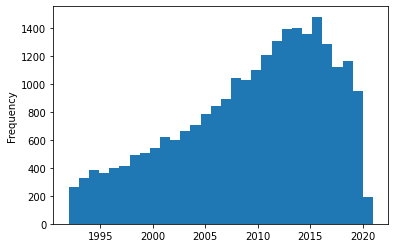

In [284]:
# histogram showing journals of the past 30 years that are not in english (on its way down after peaking in ~2013)
temp_df[(temp_df['lang']!='en') & (temp_df['year'] > 1991)]['year'].plot.hist(bins=30)
plt.show()

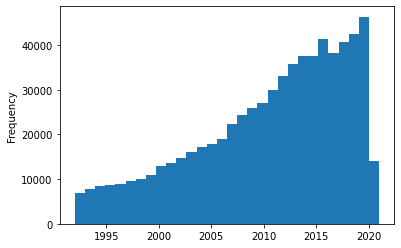

In [100]:
# histogram showing the total number of journals being published each year
df[df['year'] > 1991]['year'].plot.hist(bins=30)
plt.show()

#### Check Journals

In [92]:
cursor.execute("ROLLBACK;")
cursor.execute("SELECT * FROM mag_main_journals")
df = cursor.fetch_dataframe()

#### Check Field of Study

In [146]:
cursor.execute("ROLLBACK;")
cursor.execute("SELECT * FROM mag_advanced_fields_of_study")
mag_fields = cursor.fetch_dataframe()
mag_fields.shape

(718697, 10)

In [147]:
mag_fields['level'].value_counts()

3.0    357425
2.0    159323
4.0    124331
5.0     77303
1.0       292
0.0        19
Name: level, dtype: int64

In [149]:
mag_fields[mag_fields['level']==0.0]

,field_of_study_id,rank,normalized_name,display_name,main_type,level,paper_count,paper_family_count,citation_count,create_date
12099,127313418,5728,geology,Geology,None,0.0,7229938.0,7146333.0,39081212.0,2016-06-24
73790,205649164,6293,geography,Geography,None,0.0,4577091.0,4555936.0,21098112.0,2016-06-24
110692,185592680,4358,chemistry,Chemistry,None,0.0,18501883.0,17694356.0,238074571.0,2016-06-24
129233,33923547,5125,mathematics,Mathematics,None,0.0,6999822.0,6698419.0,81954218.0,2016-06-24
131082,192562407,4137,materials science,Materials science,None,0.0,30842052.0,29409414.0,173450325.0,2016-06-24
131509,138885662,7248,philosophy,Philosophy,None,0.0,2086370.0,2081982.0,5001790.0,2016-06-24
207151,41008148,4250,computer science,Computer science,None,0.0,26826626.0,25672825.0,151405340.0,2016-06-24
270489,17744445,6001,political science,Political science,None,0.0,6751171.0,6690167.0,21566953.0,2016-06-24
293109,39432304,5852,environmental science,Environmental science,None,0.0,6190085.0,6121022.0,36169558.0,2016-06-24
294653,15744967,5223,psychology,Psychology,None,0.0,7998148.0,7954010.0,111798077.0,2016-06-24


#### Explored patents as a feature but most likely won't work
* thought about possibly connecting through a patent API to get more information on the paper
* patent ID was sparse but also did not match up with patent database
* could possibly work with author but wouldn't be a one-to-one match every time (something that could be made to work with extra effort)

#### Looking into affiliations
* determined that it might be beneficial to add as a feature later but as of right now I will keep it out of the model

In [149]:
df.sample(10)

,paper_id,doc_type,paper_title,year,publication_date,journal_name,topic_name,level,affiliation_name
6798592,2607443536,Journal,analise histologica das brânquias e do figado ...,2017.0,2017-04-19,boletim do instituto de pesca,histology,2.0,federal university of maranhao
3618526,2872829737,Patent,information reproducing and recording device,1986.0,1986-04-24,None,synchro,2.0,None
6259769,2140391383,Journal,student loan reforms for german higher educati...,2014.0,2014-07-24,education economics,government,2.0,australian national university
56345,1977871706,Journal,reducing 30 day rehospitalization,2012.0,2012-02-07,annals of internal medicine,systematic review,3.0,northwestern university
4674002,200032764,None,linear systems and projection,1999.0,1999-01-01,None,parallel projection,3.0,university of chicago
2861311,2153140228,None,libguides research in music listen watch,2009.0,2009-05-13,None,music education,2.0,None
7812909,2131250445,Journal,simultaneous tumors acute myeloid leukemia inf...,2011.0,2011-02-01,pediatric blood & cancer,pediatric hematology oncology,2.0,None
6782890,2104224477,Journal,fuzzy dynamic programming approach to reactive...,1997.0,1997-05-01,ieee transactions on power systems,transformer,3.0,national taiwan university
2372499,1988968993,Journal,sets of convergence of ordinary dirichlet series,1954.0,1954-12-01,duke mathematical journal,dirichlet l function,5.0,None
682892,2750795160,Conference,fiber wireless convergence for next generation...,2017.0,2017-07-01,None,interface,2.0,georgia institute of technology


In [97]:
df.drop_duplicates(subset=['paper_id']).dropna(subset=['topic_name']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81364 entries, 0 to 787911
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   paper_id          81364 non-null  int64  
 1   doc_type          62867 non-null  object 
 2   paper_title       81364 non-null  object 
 3   year              81338 non-null  float64
 4   publication_date  81339 non-null  object 
 5   journal_name      35120 non-null  object 
 6   topic_name        81364 non-null  object 
 7   level             81364 non-null  float64
 8   affiliation_name  22795 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 6.2+ MB


In [84]:
df['affiliation_name'].value_counts()

chinese academy of sciences                     2291
harvard university                              1869
centre national de la recherche scientifique    1579
max planck society                              1537
university of michigan                          1526
                                                ... 
centrotherm photovoltaics                          1
peruvian academy of language                       1
consejo nacional de ciencia y tecnologia           1
northrop grumman                                   1
jenderal soedirman university                      1
Name: affiliation_name, Length: 6549, dtype: int64

In [150]:
df[df['paper_id']==2104224477].head(40)

,paper_id,doc_type,paper_title,year,publication_date,journal_name,topic_name,level,affiliation_name
246172,2104224477,Journal,fuzzy dynamic programming approach to reactive...,1997.0,1997-05-01,ieee transactions on power systems,tap changer,4.0,national taiwan university
349587,2104224477,Journal,fuzzy dynamic programming approach to reactive...,1997.0,1997-05-01,ieee transactions on power systems,control theory,1.0,national taiwan university
693790,2104224477,Journal,fuzzy dynamic programming approach to reactive...,1997.0,1997-05-01,ieee transactions on power systems,ac power,3.0,national taiwan university
1841697,2104224477,Journal,fuzzy dynamic programming approach to reactive...,1997.0,1997-05-01,ieee transactions on power systems,voltage optimisation,4.0,national taiwan university
2069238,2104224477,Journal,fuzzy dynamic programming approach to reactive...,1997.0,1997-05-01,ieee transactions on power systems,power factor,3.0,national taiwan university
3435757,2104224477,Journal,fuzzy dynamic programming approach to reactive...,1997.0,1997-05-01,ieee transactions on power systems,distribution transformer,4.0,national taiwan university
4244911,2104224477,Journal,fuzzy dynamic programming approach to reactive...,1997.0,1997-05-01,ieee transactions on power systems,engineering,0.0,national taiwan university
5401568,2104224477,Journal,fuzzy dynamic programming approach to reactive...,1997.0,1997-05-01,ieee transactions on power systems,voltage regulation,3.0,national taiwan university
6437439,2104224477,Journal,fuzzy dynamic programming approach to reactive...,1997.0,1997-05-01,ieee transactions on power systems,voltage regulator,3.0,national taiwan university
6782890,2104224477,Journal,fuzzy dynamic programming approach to reactive...,1997.0,1997-05-01,ieee transactions on power systems,transformer,3.0,national taiwan university


In [90]:
df[df['paper_id']==2947431322]['topic_name'].value_counts()

colorectal cancer                78
genetics                         78
genome wide association study    78
genetic association              78
biology                          78
genetic predisposition           78
Name: topic_name, dtype: int64

In [91]:
df[df['paper_id']==2947431322]['affiliation_name'].value_counts()

university of tennessee health science center    6
university hospitals of cleveland                6
city of hope national medical center             6
memorial sloan kettering cancer center           6
american cancer society                          6
                                                ..
cleveland clinic                                 6
university of hamburg                            6
national university of singapore                 6
memorial university of newfoundland              6
kaiser permanente                                6
Name: affiliation_name, Length: 77, dtype: int64

#### Looking at the target variable

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7913587 entries, 0 to 7913586
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   paper_id          int64  
 1   doc_type          object 
 2   paper_title       object 
 3   year              float64
 4   publication_date  object 
 5   journal_name      object 
 6   topic_name        object 
 7   level             float64
 8   affiliation_name  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 543.4+ MB


#### Average number of topics assigned to each paper:

In [128]:
df.drop(['affiliation_name'], axis=1).drop_duplicates().dropna(subset=['topic_name']) \
['paper_id'].value_counts().mean()

7.330412429350789

#### Distribution of number of topics assigned to a paper

<AxesSubplot:xlabel='num_topics'>

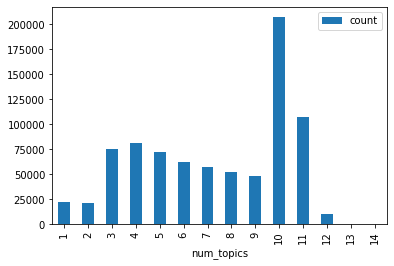

In [162]:
df.drop(['affiliation_name'], axis=1).drop_duplicates().dropna(subset=['topic_name']) \
['paper_id'].value_counts().reset_index().rename(columns={'paper_id':'num_topics'}) \
.groupby('num_topics').count().rename(columns={'index':'count'}).plot.bar()

In [163]:
df.drop(['affiliation_name'], axis=1).drop_duplicates().dropna(subset=['topic_name']) \
['paper_id'].value_counts().reset_index().rename(columns={'paper_id':'num_topics'}) \
.groupby('num_topics').count().rename(columns={'index':'count'})

,count
num_topics,
1,21938
2,21055
3,74640
4,80660
5,71626
6,62477
7,56735
8,52305
9,48254


#### Going through topics to see counts of each topic

In [129]:
topics = df.drop(['affiliation_name'], axis=1).drop_duplicates().dropna(subset=['topic_name']) \
.groupby('paper_id')['topic_name'].apply(list).to_list()

In [130]:
final_topics_list = [x for y in topics for x in y]

In [131]:
len(final_topics_list)

5971266

In [133]:
counts = Counter(final_topics_list)

In [135]:
testing_counts = pd.DataFrame(counts.items(), columns=['topic','count'])

In [137]:
testing_counts.shape

(193454, 2)

In [147]:
testing_counts[testing_counts['count'] < 5].shape

(122429, 2)

<AxesSubplot:ylabel='Frequency'>

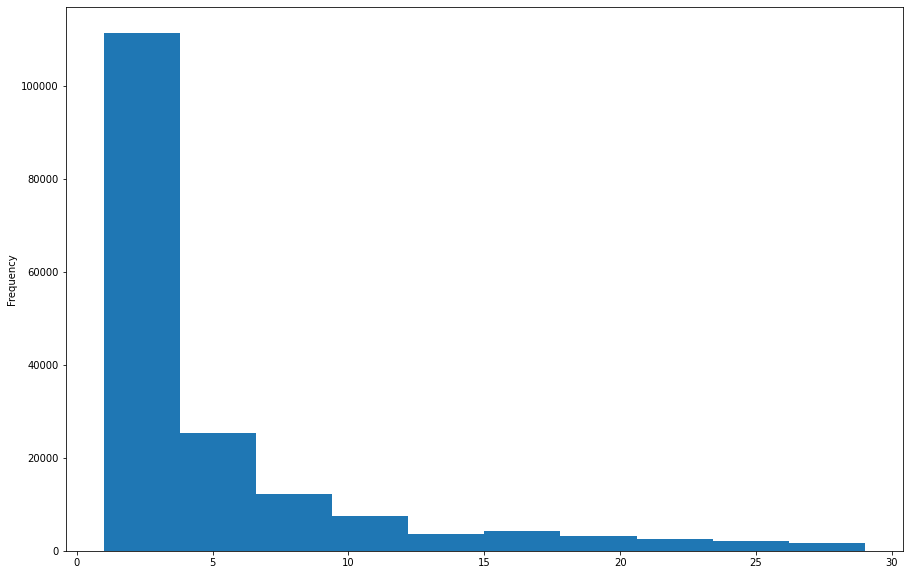

In [146]:
testing_counts[testing_counts['count'] < 30]['count'].plot.hist(figsize=(15,10),bins=10)

#### Trying to get Redshift to do the heavy lifting

In [9]:
journal_join_query = \
"""
SELECT paper_id, doc_type, paper_title, journal_name, publication_date, listagg(topic_name, '|') topics
FROM (
SELECT  a.paper_id, a.doc_type, a.paper_title, a.year, 
        a.publication_date, b.normalized_name as journal_name,
        d.normalized_name as topic_name, d.level
FROM (SELECT paper_id, doc_type, paper_title, book_title, year, 
             publication_date, online_date, journal_id
      FROM mag_main_papers 
      WHERE random() <= .1) a
LEFT JOIN (SELECT journal_id, normalized_name
           FROM mag_main_journals) b
ON a.journal_id=b.journal_id
LEFT JOIN (SELECT *
           FROM mag_advanced_paper_fields_of_study) c
ON a.paper_id=c.paper_id
LEFT JOIN (SELECT *
           FROM mag_advanced_fields_of_study) d
ON c.field_of_study=d.field_of_study_id )
WHERE topic_name IS NOT NULL
GROUP BY paper_id, doc_type, paper_title, journal_name, publication_date
"""

In [10]:
%%time
cursor.execute("ROLLBACK;")
cursor.execute(journal_join_query)
df = cursor.fetch_dataframe()
df.shape

CPU times: user 3min 42s, sys: 2min 18s, total: 6min
Wall time: 8min 46s


(20348766, 6)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20348766 entries, 0 to 20348765
Data columns (total 6 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   paper_id          int64 
 1   doc_type          object
 2   paper_title       object
 3   journal_name      object
 4   publication_date  object
 5   topics            object
dtypes: int64(1), object(5)
memory usage: 931.5+ MB


In [12]:
df['topics'] = df['topics'].apply(lambda x: x.split("|"))

In [14]:
df['publication_date'] = pd.to_datetime(df['publication_date'])

In [7]:
# df.to_parquet("test_data_to_try.parquet")

In [8]:
df = pd.read_parquet("test_data_to_try.parquet")

In [9]:
df.shape

(20348766, 6)

In [14]:
df['publication_date'].min()

Timestamp('1800-01-01 00:00:00')

In [15]:
df['publication_date'].max()

Timestamp('2022-01-01 00:00:00')

In [20]:
df.dropna(subset=['publication_date']).sort_values('publication_date').head(50)

,paper_id,doc_type,paper_title,journal_name,publication_date,topics
15293684,2772991433,None,report put reading first for parents,None,1800-01-01,"[reading, psychology, mathematics education]"
7589758,1582345295,Book,versuch einer geschichte der kultur des menschlichen geschlechts,None,1800-01-01,[philosophy]
5230827,2567918209,None,dictionnaire de l academie francoise,None,1800-01-01,[art]
7524144,2467735828,None,overture to the opera of fra diavolo,None,1800-01-01,"[art, humanities, opera]"
9267305,2593091787,None,strain analyses of nonlinear crack behavior at elevated temperature by finite element method and moire topographical method,None,1800-01-01,"[engineering drawing, finite element method, moire pattern, composite material, materials science, strain, nonlinear system]"
20280717,2491217040,None,xv explanation of a seal of the abbey of lundores in scotland by the rev john brand secretary in a letter addressed to owen salusbury brereton esq vice president,None,1800-01-01,"[pece, seal, saint, theology, law, history, vice president]"
6759308,2622545586,None,a comparison of observed behaviors of four year olds with theory predicted behaviors extrapolated from freud s and kohlberg s theories of psychosexual development,None,1800-01-01,"[psychology, psychosexual development, lawrence kohlberg s stages of moral development, developmental psychology]"
3227004,3008377260,Book,periplus of the erythrean sea,None,1800-01-01,"[ancient history, geography]"
14531084,3127251568,Book,poems on several occasions,None,1800-01-01,"[literature, poetry, art]"
5913139,2613628177,None,microfluidics in the undergraduate analytical lab and in outreach projects,None,1800-01-01,"[engineering, outreach, microfluidics, engineering management]"


In [36]:
df[(df['publication_date'] > "1950-01-01") & (df['publication_date'] < "2021-06-01")].shape

(19857210, 6)

In [34]:
df[(df['publication_date'] >= "2021-06-01") & (df['publication_date'] < "2021-10-01")].shape

(5199, 6)

##### Save Train, Test, Val

In [37]:
shuffled_df = df[(df['publication_date'] > "1950-01-01") & 
                 (df['publication_date'] < "2021-06-01")].sample(19857210).copy()

In [40]:
train = shuffled_df.iloc[:19000000,:].copy()
val = shuffled_df.iloc[19000000:, :].copy()

In [41]:
test = df[(df['publication_date'] >= "2021-06-01") & (df['publication_date'] < "2021-10-01")].copy()

In [42]:
train.shape

(19000000, 6)

In [44]:
val.shape

(857210, 6)

In [43]:
test.shape

(5199, 6)

In [46]:
# train.to_parquet("./data/testing/train/train_raw.parquet")
# val.to_parquet("./data/testing/val/val_raw.parquet")
# test.to_parquet("./data/testing/test/test_raw.parquet")

#### Creating the vocabs

In [2]:
train = pd.read_parquet("./data/testing/train/train_raw.parquet")
val = pd.read_parquet("./data/testing/val/val_raw.parquet")
test = pd.read_parquet("./data/testing/test/test_raw.parquet")

In [3]:
train.head(1)

,paper_id,doc_type,paper_title,journal_name,publication_date,topics
17423410,611508574,None,libguides topic mudskippers home,None,2010-04-13,[library science]


In [4]:
type(train['topics'][0])

numpy.ndarray

In [12]:
def get_value_counts_for_column(data, col_name):
    if type(data.dropna(subset=[col_name]).reset_index(drop=True)[col_name][0])==str:
        counts_df = data[['paper_id', col_name]].dropna().groupby(col_name).count() \
        .rename(columns={'paper_id':'count'}).reset_index().sort_values('count', ascending=False)
    elif type(data.dropna(subset=[col_name]).reset_index(drop=True)[col_name][0])==np.ndarray:
        col_list = data[col_name].to_list()
        flat_col_list = [x for y in col_list for x in y]
        counts = Counter(flat_col_list)
        counts_df = pd.DataFrame(counts.items(), columns=[col_name,'count']).sort_values('count', ascending=False)
    else:
        counts_df = None
        print("Failed")
    
    return counts_df


def create_vocab(data, col_name, cutoff=5, unk_token=True, none_token=True):
    
    val_counts = get_value_counts_for_column(data, col_name)
    
    val_counts.columns = [f"{col_name}_token", "count"]
    
    final_vocab_df = val_counts[val_counts['count'] >= cutoff].copy()
    
    if unk_token & none_token:
        token_list = ["[UNK]"] + ["[NONE]"] + list(final_vocab_df[f"{col_name}_token"])
    elif unk_token:
        token_list = ["[UNK]"] + list(final_vocab_df[f"{col_name}_token"])
    elif none_token:
        token_list = ["[NONE]"] + list(final_vocab_df[f"{col_name}_token"])
    else:
        token_list = list(final_vocab_df[f"{col_name}_token"])
        
    index_list = list(range(1, len(token_list)+1))
    
    final_vocab = dict(zip(token_list, index_list))
    
    return final_vocab

In [9]:
get_value_counts_for_column(train, "doc_type")
get_value_counts_for_column(train, "journal_name")
get_value_counts_for_column(train, "topics")

,doc_type,count
4,Journal,7778081
5,Patent,5134310
2,Conference,477646
6,Repository,428268
7,Thesis,306351
0,Book,294107
1,BookChapter,235961
3,Dataset,10817


In [14]:
test_df = get_value_counts_for_column(train, "topics")

In [15]:
test_df.shape

(448354, 2)

In [16]:
test_df[test_df['count']==1].shape

(100357, 2)

#### Creating the features

In [ ]:
def tokenize_feature(feature, vocab, unk_token=True, none_token=True, is_arr=True):
    if unk_token & none_token:
        unk_token_id = products_vocab.get('[UNK]')
        none_token_id = products_vocab.get('[NONE]')
        
        if is_arr:
            pass
        else:
            pass
        
        
        
    elif unk_token:
        unk_token_id = products_vocab.get('[UNK]')
        
        if is_arr:
            pass
        else:
            pass
        
    elif none_token:
        none_token_id = products_vocab.get('[NONE]')
        
        if is_arr:
            pass
        else:
            pass
    
    else:
        if is_arr:
            pass
        else:
            pass

In [ ]:
def tokenize_column(data, col_name, cutoff=5, unk_token=True, none_token=True):
    vocab = create_vocab(data, col_name, cutoff, unk_token, none_token)
    
    if type(data.dropna(subset=[col_name]).reset_index(drop=True)[col_name][0])==str:
        data[col_name] = data[col_name].apply(lambda x: tokenize_feature(x, vocab, unk_token, none_token, False))
    elif type(data.dropna(subset=[col_name]).reset_index(drop=True)[col_name][0])==np.ndarray:
        data[col_name] = data[col_name].apply(lambda x: tokenize_feature(x, vocab, unk_token, none_token, True))
    else:
        print("Tokenize failure")
        
    return data
    
        

In [ ]:
tokenize_column(train, "doc_type", cutoff=1, unk_token=False, none_token=True)
tokenize_column(train, "journal_name", cutoff=4, unk_token=True, none_token=True)
tokenize_column(train, "topics", cutoff=2, unk_token=True, none_token=True)